<a href="https://colab.research.google.com/github/Fernandovj/DeepSARA/blob/master/DL_ProjetoFinal_Baseline_Beehealthclassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load the packages, load and inspect the data**

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
# file_id ='1a-GaQxHLWsNk_xVUxI6gPR5akagk9_vB' #ID Colab/bees/bees.zip
file_id ='1cZT0QTaMMRs_mPghOOAF9-WcvuZ1duZp' #ID Colab/bees/bees.zip

downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('bees.zip')
!unzip -q bees.zip

In [ ]:
# !rm -rf /content/bee_imgs/

In [ ]:
%matplotlib inline
import csv
from random import shuffle
import cv2 #to read images
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import sys

import imageio
import skimage
import skimage.io
import skimage.transform

import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization,LeakyReLU, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks

In [ ]:
IMG_PATH = '/content/bee_imgs/bee_imgs'


In [ ]:
bee_df=pd.read_csv('/content/bee_data.csv')
bee_df.shape
bee_df.sample(10).head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
3631,001_051.png,8/25/18,14:00,"Keene, NH, USA",3431,Russian honey bee,healthy,False,worker
2973,010_706.png,8/19/18,12:46,"Des Moines, IA, USA",50315,Carniolan honey bee,healthy,False,worker
2719,010_137.png,8/19/18,12:46,"Des Moines, IA, USA",50315,Carniolan honey bee,healthy,False,worker
173,017_126.png,8/6/18,13:21,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker
3412,015_1195.png,8/6/18,13:19,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker


The data contains the following values:

    file - the image file name;
    date - the date when the picture was taken;
    time - the time when the picture was taken;
    location - the US location, with city, state and country names;
    zip code - the ZIP code associated with the location;
    subspecies - the subspecies to whom the bee in the current image belongs;
    health - this is the health state of the bee in the current image;
    pollen_carrying - indicates if the picture shows the bee with pollen attached to the legs;
    caste - the bee caste;


**Check the missing data**

In [ ]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', '%'])
missing_data(bee_df)

,Total,%
caste,0,0.0
pollen_carrying,0,0.0
health,0,0.0
subspecies,0,0.0
zip code,0,0.0
location,0,0.0
time,0,0.0
date,0,0.0
file,0,0.0


In [ ]:
image_files = list(os.listdir(IMG_PATH))
print("Number of image files: {}".format(len(image_files)))

Number of image files: 5172


Checking the image sizes

In [ ]:
def read_image_sizes(file_name):
    image = skimage.io.imread(IMG_PATH+'/'+ file_name)
    return list(image.shape)

In [ ]:
m = np.stack(bee_df['file'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c'])
bee_df = pd.concat([bee_df,df],axis=1, sort=False)
bee_df.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste,w,h,c
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,115,164,3
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,201,90,3
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,132,167,3
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,134,97,3
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,147,106,3


Checking the size distribution of images

Text(0.5, 0, 'Width')

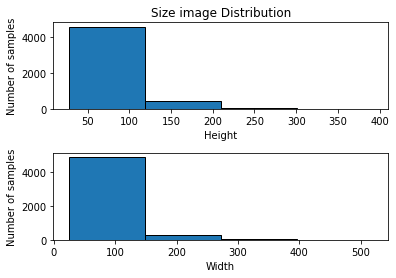

In [ ]:
fig, (ax1,ax2) = plt.subplots(nrows=2)
ax1.hist(bee_df['h'],bins=4,edgecolor='black')
ax1.set_ylabel('Number of samples')
ax1.set_xlabel('Height')
ax1.set_title('Size image Distribution')
plt.subplots_adjust(hspace = 0.5)
ax2.hist(bee_df['w'],bins=4,edgecolor='black')
ax2.set_ylabel('Number of samples')
ax2.set_xlabel('Width')

Health sample distribution

healthy                       3384
few varrao, hive beetles       579
Varroa, Small Hive Beetles     472
ant problems                   457
hive being robbed              251
missing queen                   29
Name: health, dtype: int64



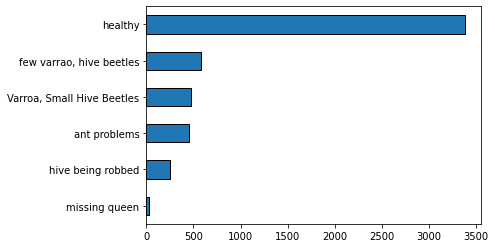

In [ ]:
print(bee_df.health.value_counts())
print()
bee_df.health.value_counts().sort_values().plot(kind = 'barh',edgecolor='black')


Healt sample size distribution

Text(0.5, 1.0, 'Healt sample size distribution')

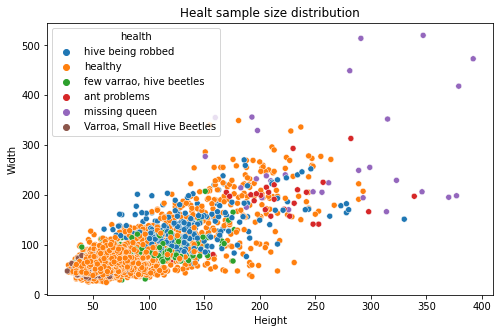

In [ ]:
plt.figure(figsize=(8,5))
ax =sns.scatterplot(x='h', y='w', data=bee_df, hue="health")
ax.set(xlabel='Height', ylabel='Width')
plt.title('Healt sample size distribution')


# **BASELINE**

**Splitting data**

First, we split the whole dataset in train and test. We will use random_state to ensure reproductibility of results.

The train-test split is 80% for training set and 20% for test set.

In [ ]:
train_df, test_df = train_test_split(bee_df, test_size=0.2, random_state=2018,stratify=bee_df['health'])

Next, we will split further the train set in train and validation. We want to use as well a validation set to be able to measure not only how well fits the model the train data during training (or how well learns the training data) but also how well the model is able to generalize so that we are able to understands not only the bias but also the variance of the model.

The train-validation split is 80% for training set and 20% for validation set.


In [ ]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=2018, stratify=train_df['health'])


In [ ]:
print("Train set samples: {}".format(train_df.shape[0]))
print("Test  set samples: {}".format(test_df.shape[0]))
print("Val   set samples: {}".format(val_df.shape[0]))

Train set samples: 3309
Test  set samples: 1035
Val   set samples: 828


A function for reading images from the image files, scale all images to 100 x 100
 x 3 (channels).

In [ ]:
def read_image(file_name):
    image = skimage.io.imread(IMG_PATH +'/'+ file_name)
    image = skimage.transform.resize(image, (100, 100), mode='reflect')
    return image[:,:,:3]

In [ ]:
def categories_encoder(dataset, var='health'):
    X = np.stack(dataset['file'].apply(read_image))
    y = pd.get_dummies(dataset[var], drop_first=False)
    return X, y

In [ ]:
X_train, y_train = categories_encoder(train_df)
X_val, y_val = categories_encoder(val_df)
X_test, y_test = categories_encoder(test_df)


**Define baseline model**

In [ ]:

model_baseline = Sequential()
model_baseline.add(Conv2D(10,3,3, input_shape=(100,100,3)))
model_baseline.add(MaxPooling2D(pool_size=(2,2)))
model_baseline.add(Flatten())
model_baseline.add(Dense(6, activation="softmax"))
model_baseline.summary()

#smaller learning rate to optimize better. Default has periodic dips
model_baseline.compile(optimizer=optimizers.Adam(lr=0.0005), loss="categorical_crossentropy",metrics=["accuracy"])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 33, 33, 10)        280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 15366     
Total params: 15,646
Trainable params: 15,646
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_batch = ImageDataGenerator().flow(X_train, y_train, batch_size=32)
valid_batch = ImageDataGenerator().flow(X_val, y_val, batch_size=32)

In [ ]:
history  = model_baseline.fit(train_batch, validation_data=valid_batch, epochs=50)

Epoch 1/50
104/104 [==============================] - 1s 7ms/step - loss: 1.0846 - accuracy: 0.6461 - val_loss: 0.9580 - val_accuracy: 0.6957
Epoch 2/50
104/104 [==============================] - 1s 6ms/step - loss: 0.8679 - accuracy: 0.6893 - val_loss: 0.7919 - val_accuracy: 0.6944
Epoch 3/50
104/104 [==============================] - 1s 6ms/step - loss: 0.7500 - accuracy: 0.7165 - val_loss: 0.7008 - val_accuracy: 0.7428
Epoch 4/50
104/104 [==============================] - 1s 6ms/step - loss: 0.6670 - accuracy: 0.7404 - val_loss: 0.6509 - val_accuracy: 0.7512
Epoch 5/50
104/104 [==============================] - 1s 6ms/step - loss: 0.6180 - accuracy: 0.7652 - val_loss: 0.6078 - val_accuracy: 0.7778
Epoch 6/50
104/104 [==============================] - 1s 6ms/step - loss: 0.5753 - accuracy: 0.7809 - val_loss: 0.5856 - val_accuracy: 0.7935
Epoch 7/50
104/104 [==============================] - 1s 6ms/step - loss: 0.5642 - accuracy: 0.7854 - val_loss: 0.5734 - val_accuracy: 0.7959
Epoch 

In [ ]:
#Auxiliar fuctions for plotting:

def plot_loss_accuracy_list(historyList, title, legend, plotSet="both", acc="accuracy"):
    linestyles = ['-', '--', ':', '-.']
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, dpi=100)

    #Plot Loss
    for idx,hist in enumerate(historyList):
        if plotSet in ["train", "both"]:
            ax1.plot(hist.history['loss'], linestyle=linestyles[idx%len(linestyles)])
        if 'val_loss' in hist.history.keys() and plotSet in ["valid", "both"]:
            ax1.plot(hist.history['val_loss'], linestyle=linestyles[idx%len(linestyles)])
    ax1.set_ylabel('Loss')
    ax1.set_title(title)

    #Plot ACC
    for idx,hist in enumerate(historyList):
      if plotSet in ["train", "both"]:
          ax2.plot(hist.history[acc], linestyle=linestyles[idx%len(linestyles)])
      if 'val_'+acc in hist.history.keys() and plotSet in ["valid", "both"]:
          ax2.plot(hist.history['val_'+acc], linestyle=linestyles[idx%len(linestyles)])
    ax2.set_ylabel('ACC')
    
    plt.legend(legend, bbox_to_anchor=(1.05, 1), loc='center left') 
    plt.subplots_adjust(right=0.75)
    plt.show()


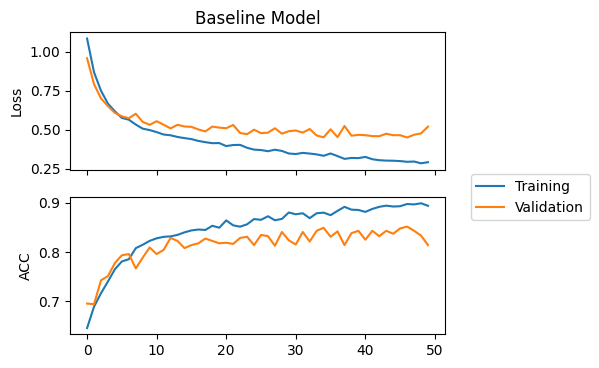

In [ ]:
legend = ['Training', 'Validation']
#print(history.history)
plot_loss_accuracy_list([history], "Baseline Model", legend)